In [1]:
import numpy as np
import pickle, os, math
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import statsmodels.api as sm
from sklearn.decomposition import PCA
from scipy.stats import spearmanr
from scipy.spatial.distance import jensenshannon

In [2]:
root_folder = '../../Data/GC_Bias_Analysis'

In [3]:
dic = None
with open(f'{root_folder}/ref_genome_GC.pkl', 'rb') as f:
    dic = pickle.load(f)
ref_GC_array = dic['GC_array'] # (22, 350, 101)


def interpolate_zero_elements(array):
    # Find the start and end indices where the first and last non-zero elements occur
    first_non_zero_index = np.argmax(array != 0)
    last_non_zero_index = len(array) - 1 - np.argmax(array[::-1] != 0)

    # Isolate the portion of the array that needs interpolation
    inner_array = array[first_non_zero_index:last_non_zero_index + 1]

    # Get the indices of the non-zero elements in the inner array
    non_zero_indices = np.nonzero(inner_array)[0]

    # Get the indices of the zero elements in the inner array
    zero_indices = np.where(inner_array == 0)[0]

    # Interpolate to fill in the zero elements with the nearest non-zero values
    inner_array[zero_indices] = np.interp(zero_indices, non_zero_indices, inner_array[non_zero_indices])

    # Place the interpolated inner array back into the original array
    array[first_non_zero_index:last_non_zero_index + 1] = inner_array
    return array

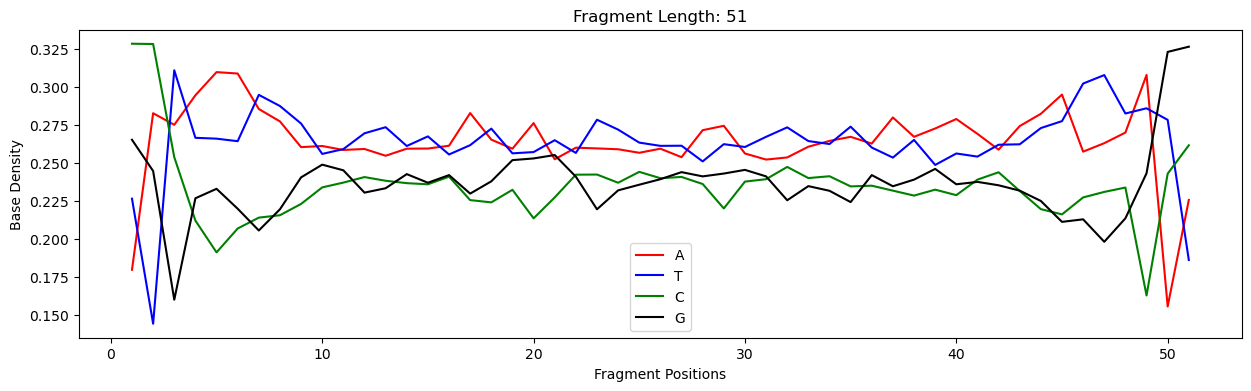

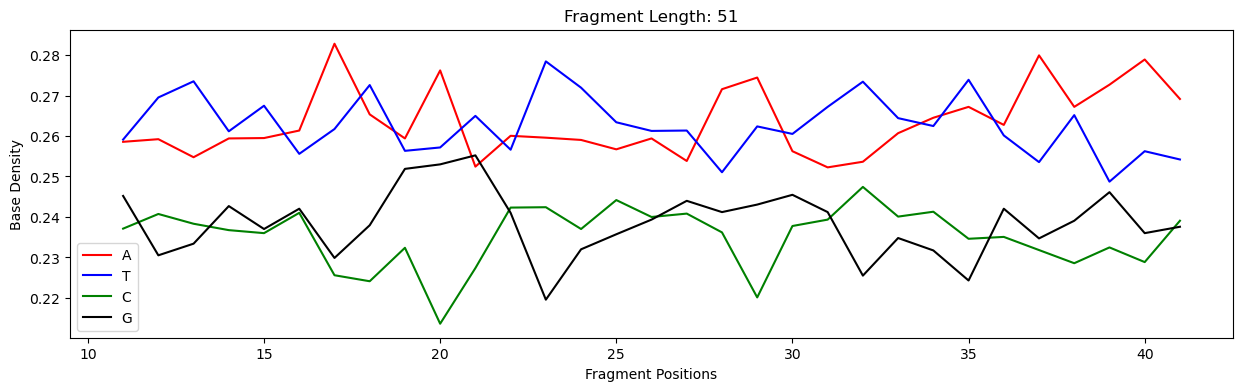

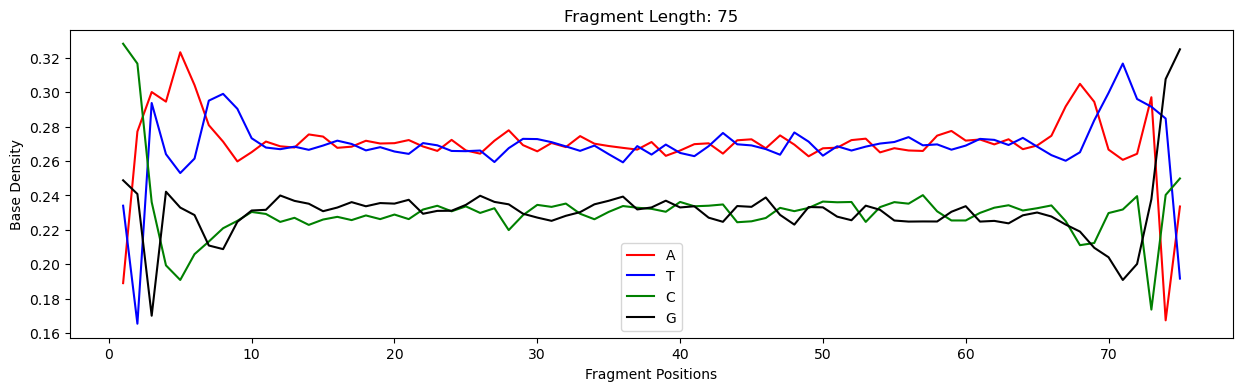

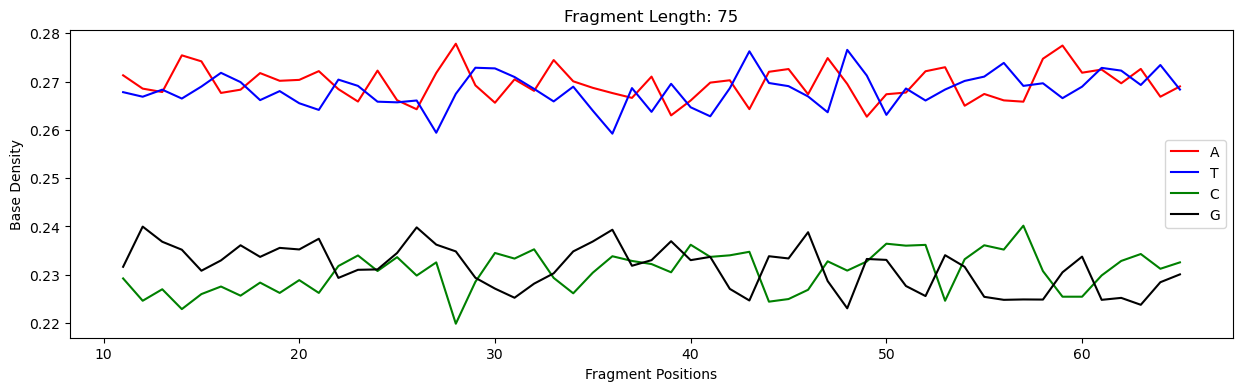

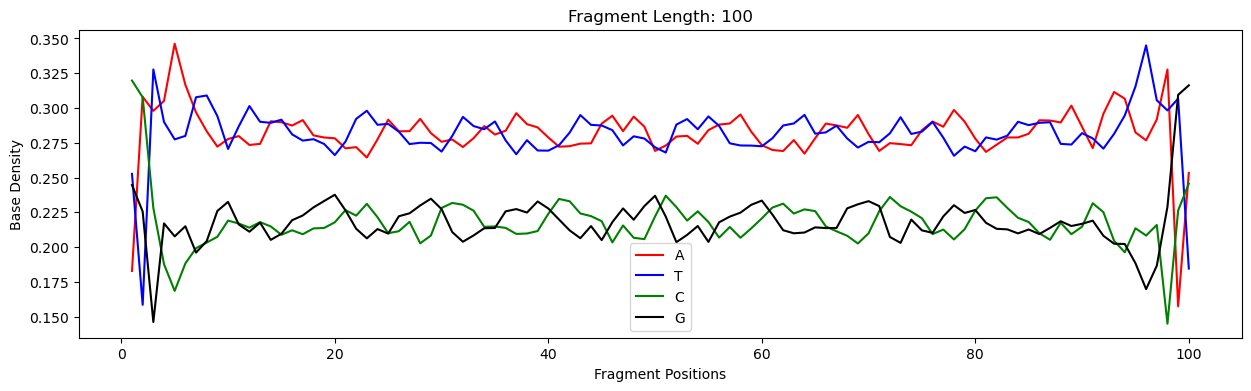

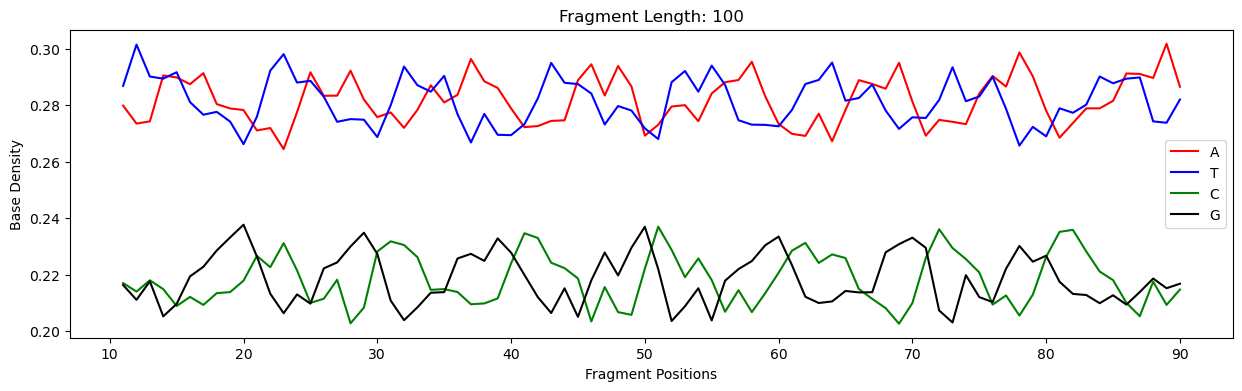

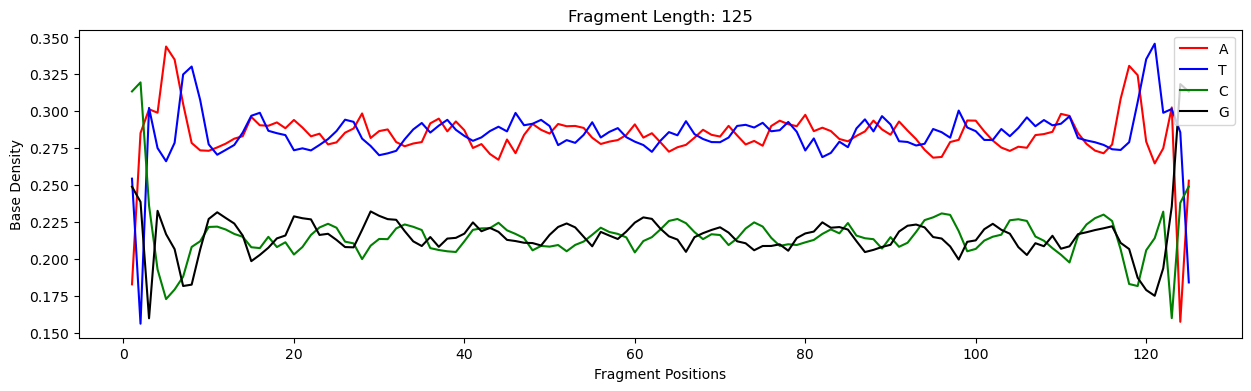

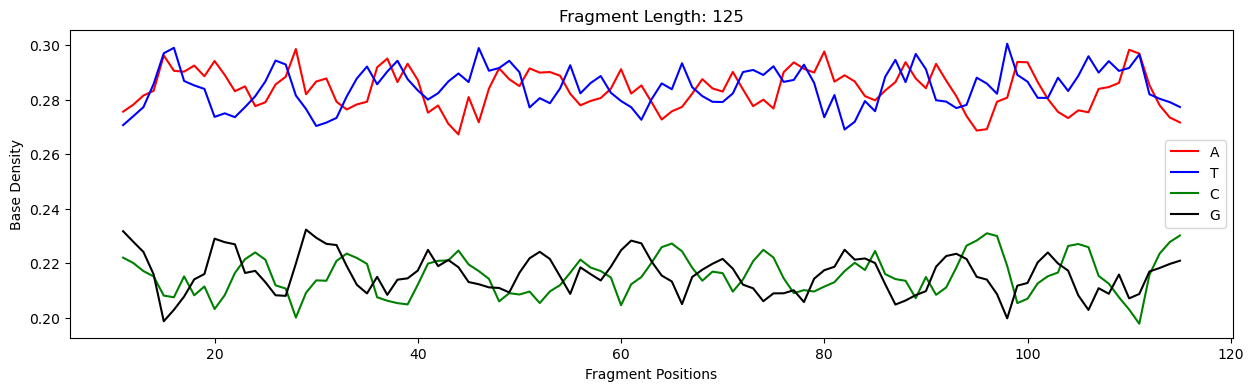

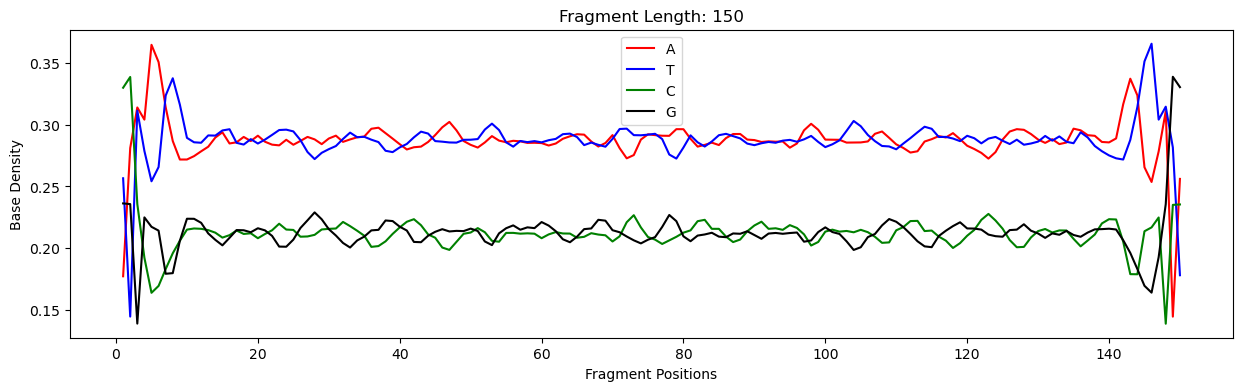

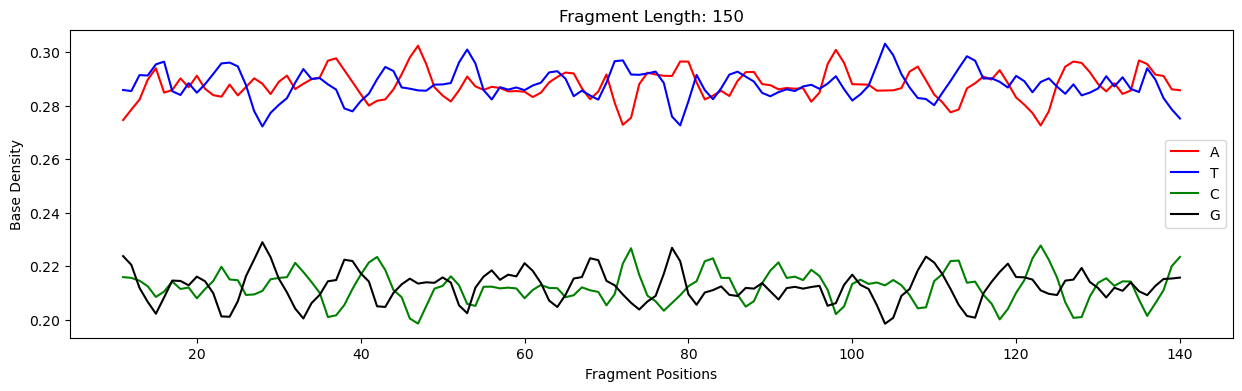

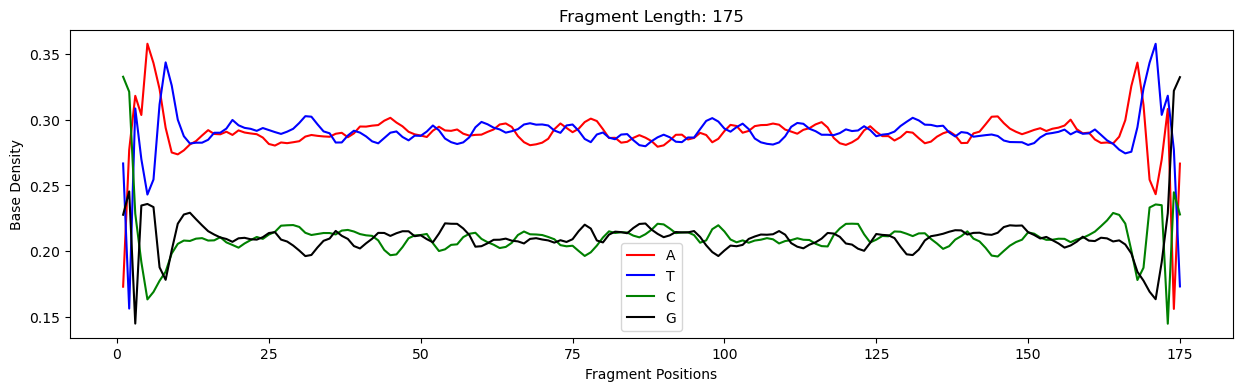

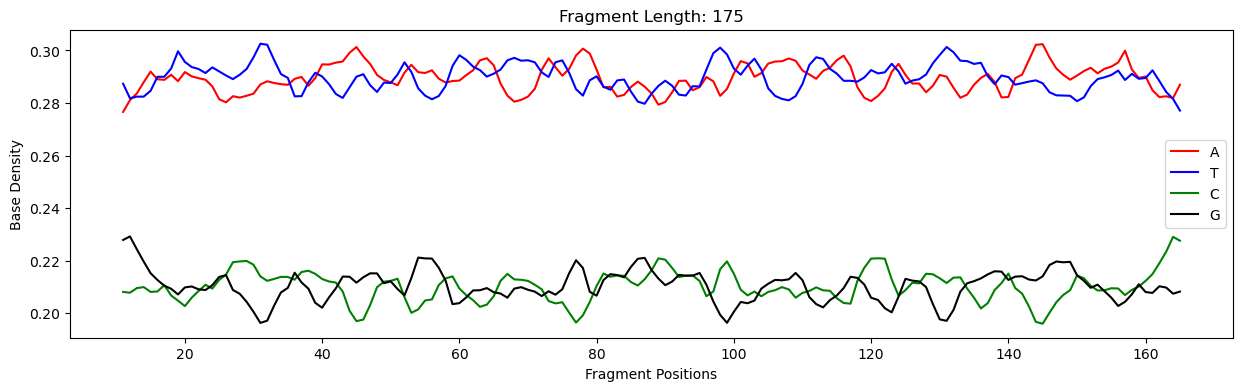

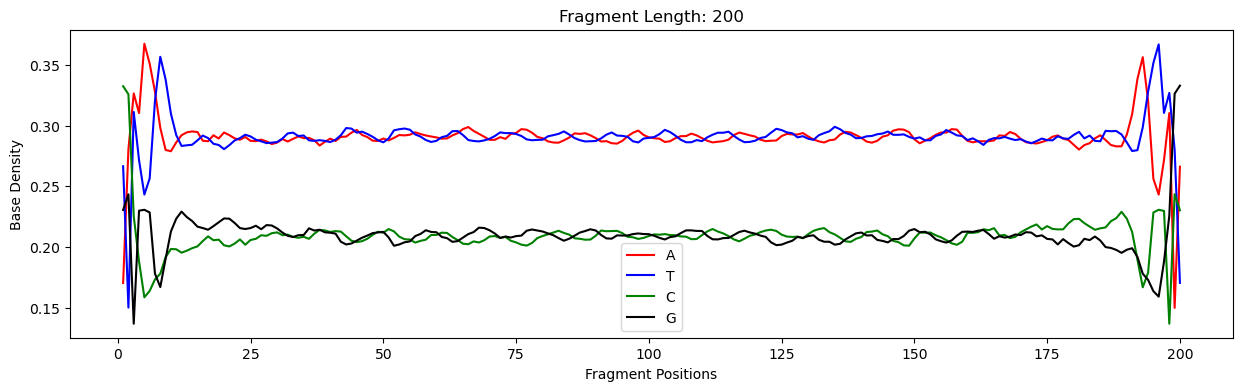

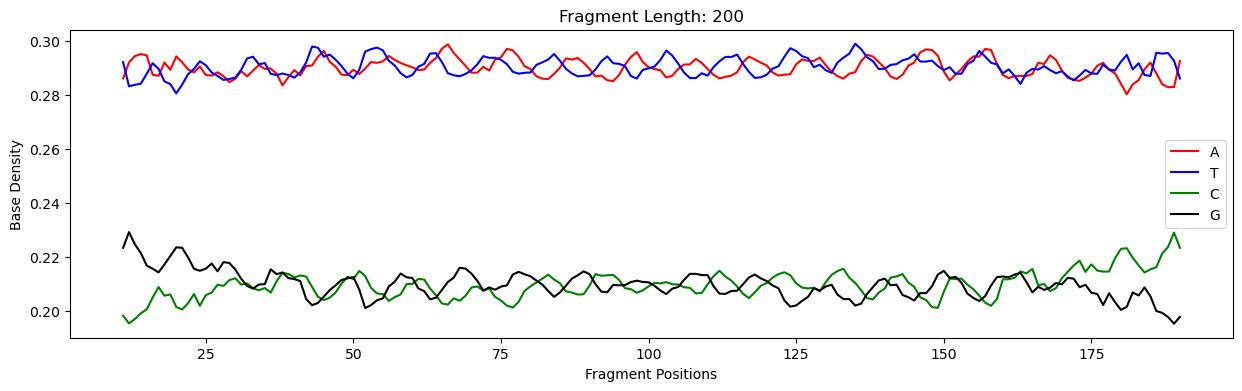

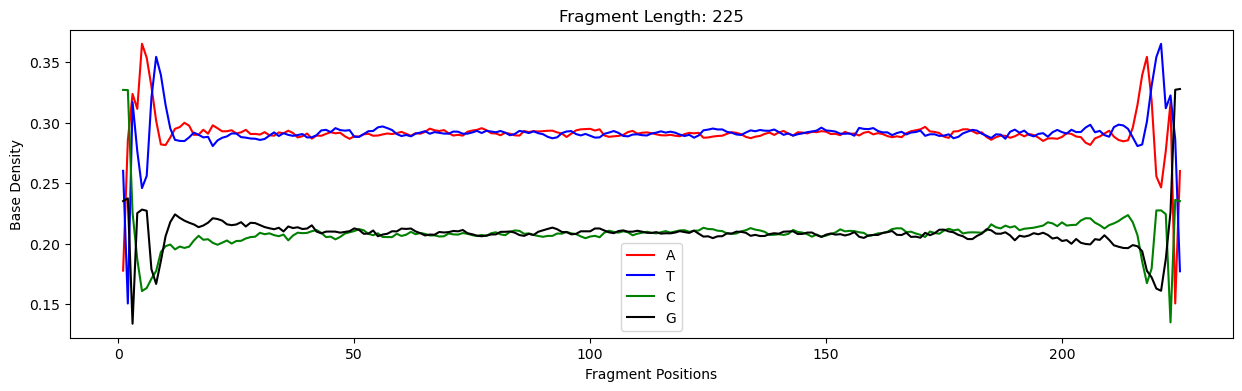

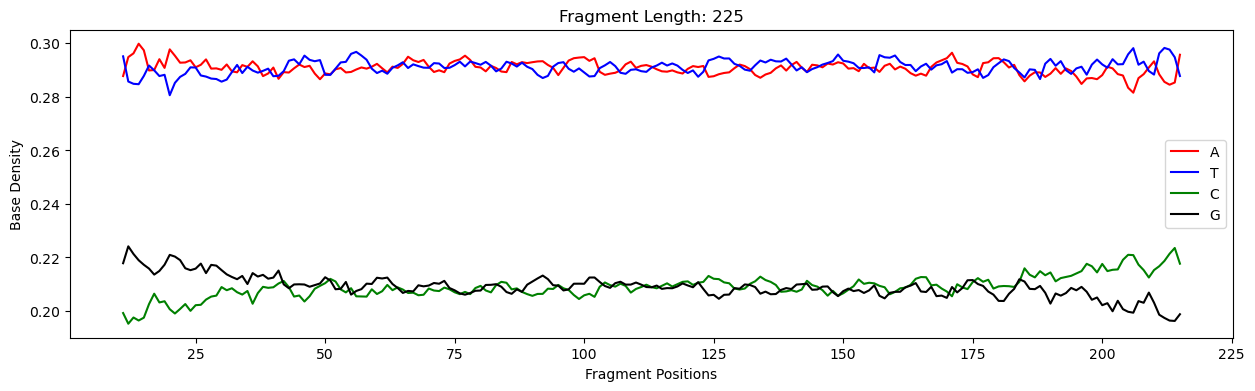

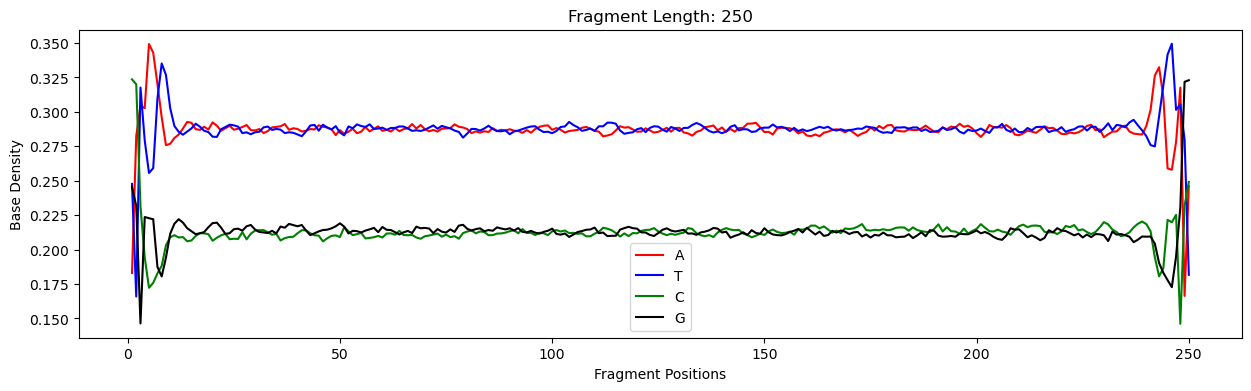

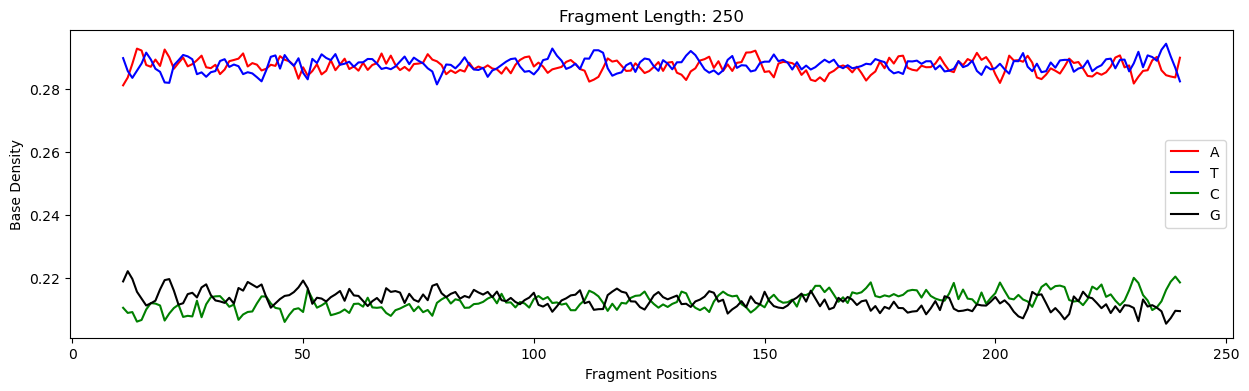

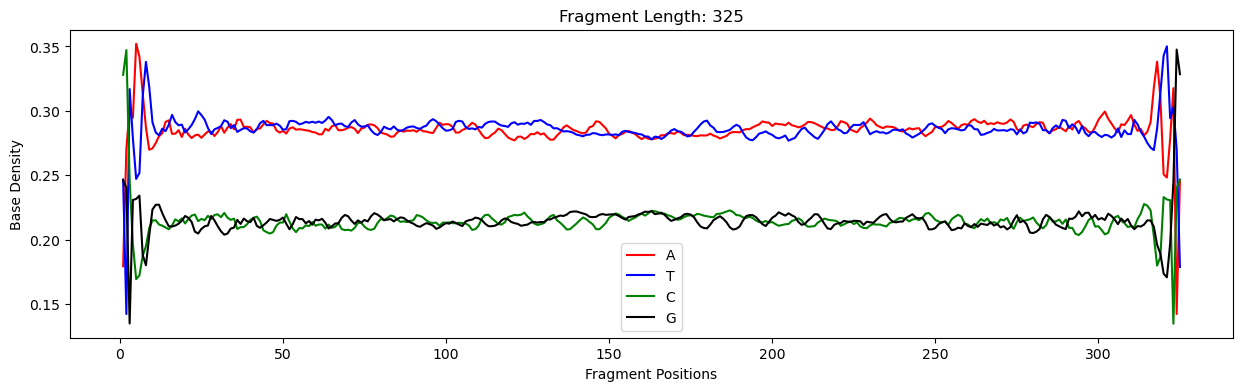

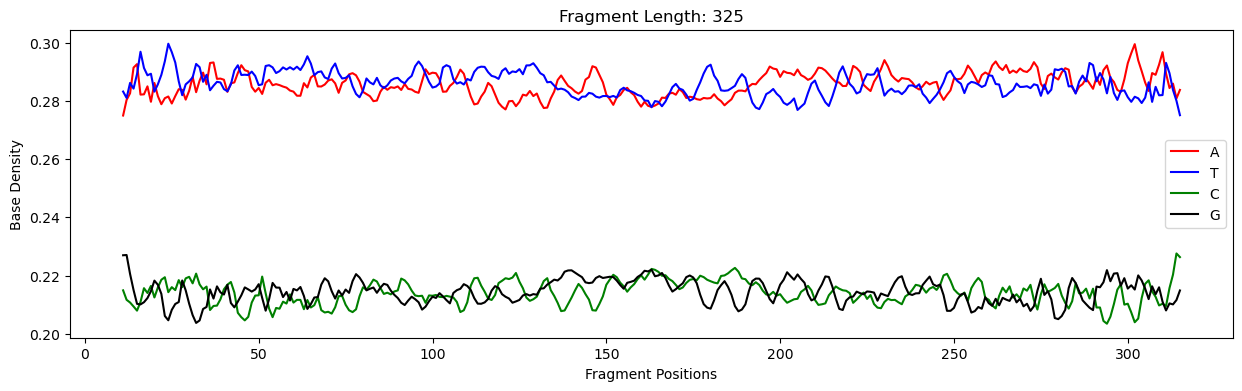

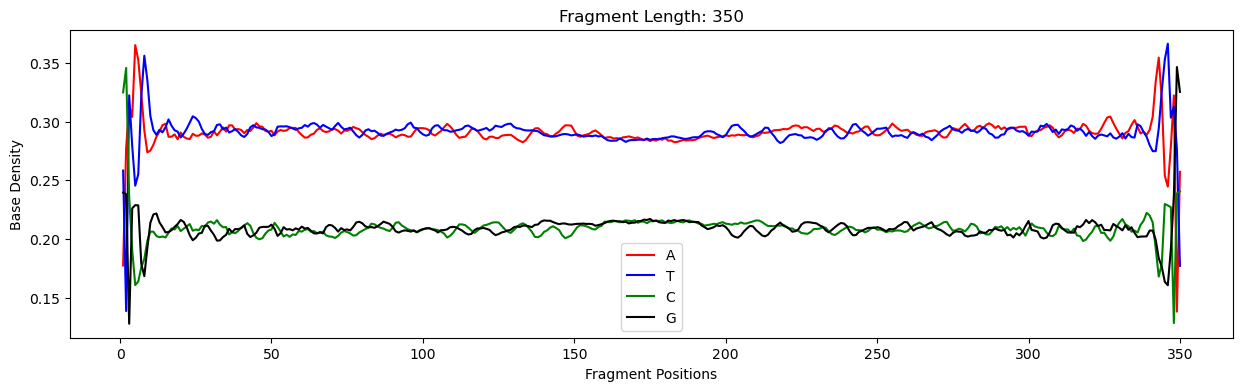

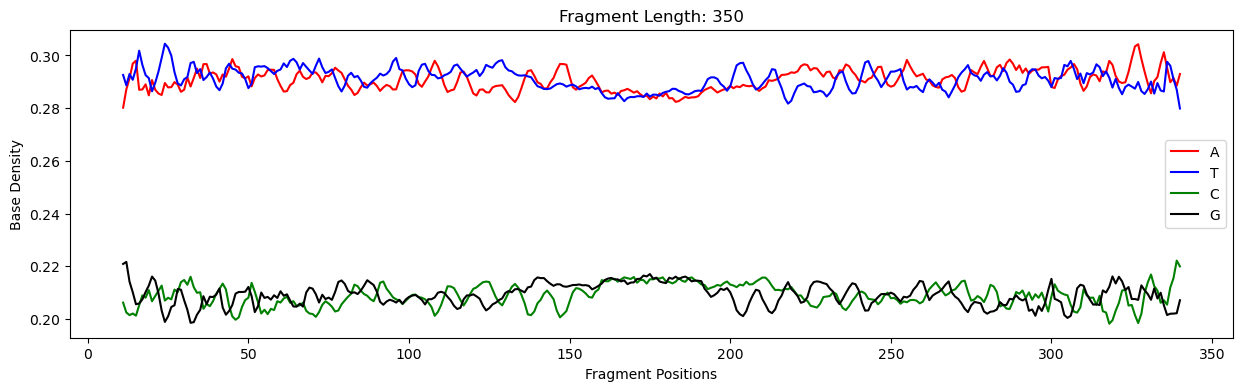

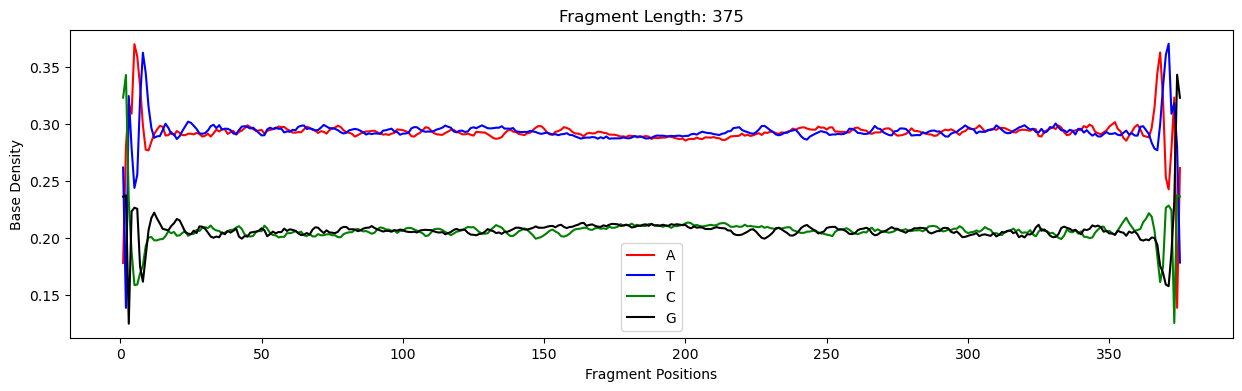

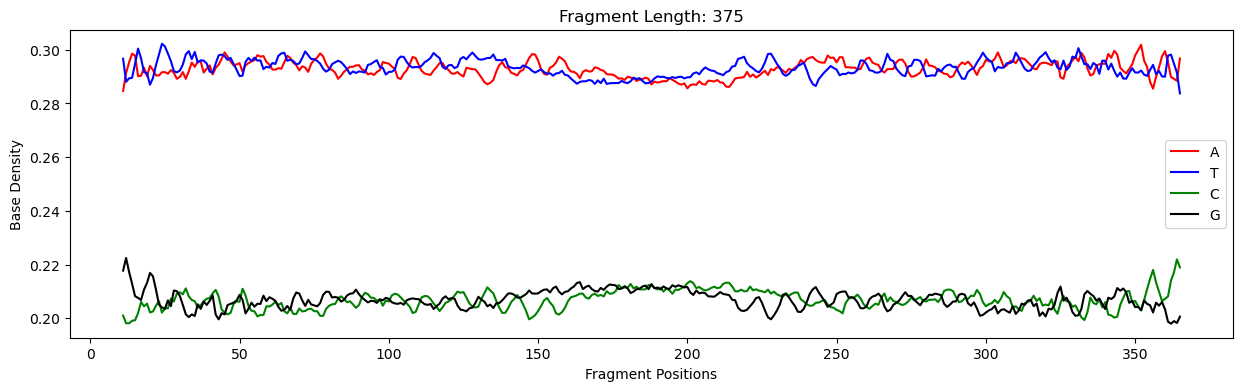

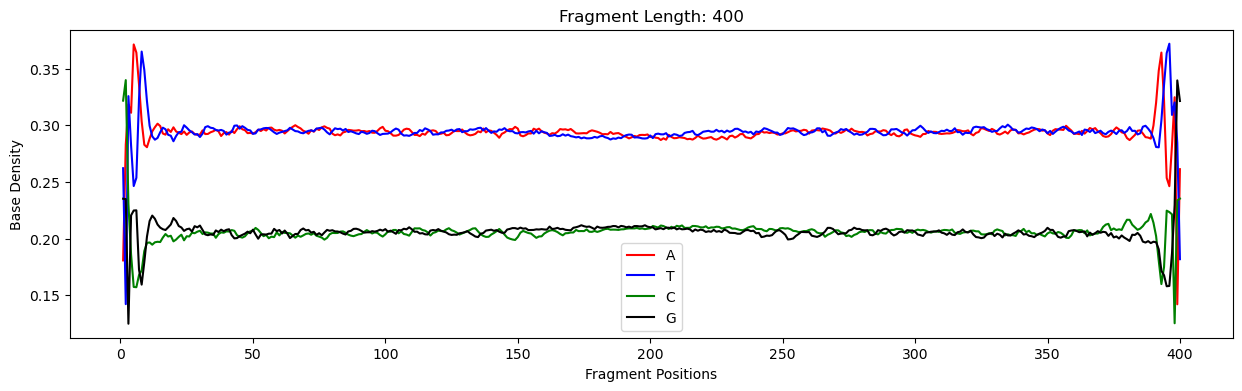

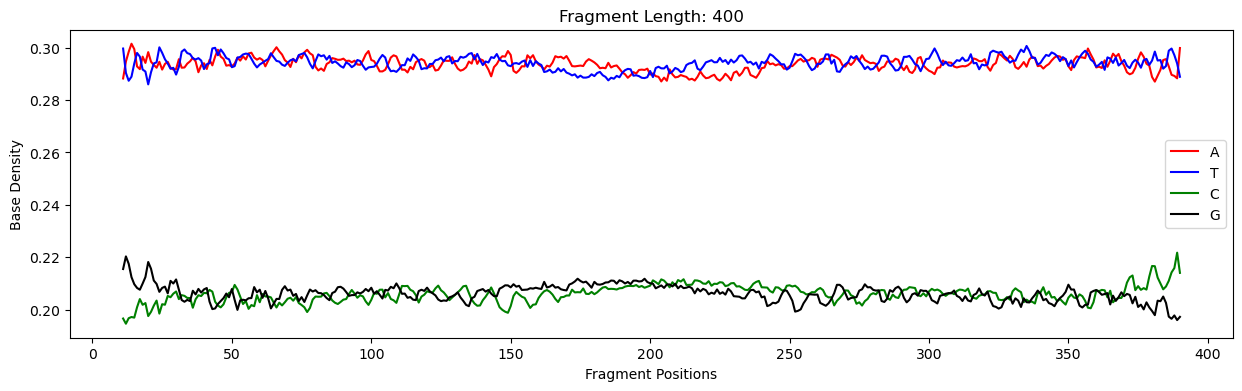

In [14]:
# we are going to plot for these fragment lengths
# lengths = [100, 150, 250, 350] -> we are going to use these fragment lengths for showing in the paper
lengths = [51, 75, 100, 125, 150, 175, 200, 225, 250, 325, 350, 375, 400]
ind_to_lens = {}
for i in range(len(lengths)):
    ind_to_lens[i] = lengths[i]
ind_to_bases = {0:'A', 1:'T', 2:'C', 3:'G'}


def plot_position_freq_no_lag(sample, len_ind):
    global ind_to_lens, ind_to_bases
    base_to_colors = {'A': 'red', 'T': 'blue', 'C': 'green', 'G': 'black'}
    len_freqs = sample[len_ind, :, :] # (400, 4)
    length = ind_to_lens[len_ind]
    X = [i for i in range(1, length+1)]
    Y = len_freqs[:length, :]
    Y = Y / np.sum(Y, axis=1)[:, np.newaxis]
    plt.figure(figsize=(15, 4))
    for i in range(Y.shape[1]):
        y = Y[:, i]
        base_char = ind_to_bases[i]
        plt.plot(X, y, label=base_char, color=base_to_colors[base_char])
    plt.xlabel('Fragment Positions')
    plt.ylabel('Base Density')
    plt.title(f'Fragment Length: {length}')
    plt.legend()
    if len_ind==4:
        plt.savefig(f'subfigures/no_lag.png', dpi=300)
    else:
        plt.show()
    

def plot_position_freq_lagged(sample, len_ind, left_lag, right_lag):
    global ind_to_lens, ind_to_bases
    base_to_colors = {'A': 'red', 'T': 'blue', 'C': 'green', 'G': 'black'}
    len_freqs = sample[len_ind, :, :] # (400, 4)
    length = ind_to_lens[len_ind]
    X = [i for i in range(1+left_lag, length+1-right_lag)]
    Y = len_freqs[left_lag: length-right_lag, :]
    Y = Y / np.sum(Y, axis=1)[:, np.newaxis]
    plt.figure(figsize=(15, 4))
    for i in range(Y.shape[1]):
        y = Y[:, i]
        base_char = ind_to_bases[i]
        plt.plot(X, y, label=base_char, color=base_to_colors[base_char])
    plt.xlabel('Fragment Positions')
    plt.ylabel('Base Density')
    plt.title(f'Fragment Length: {length}')
    plt.legend()
    if len_ind==4:
        plt.savefig(f'subfigures/lag.png', dpi=300)
    else:
        plt.show()

    
def main_func(sample_name):
    sample_file = f'{root_folder}/fragment_end_bias/{sample_name}.npy'
    sample = np.load(sample_file)
    for i in range(len(lengths)):
        plot_position_freq_no_lag(sample, i)
        plot_position_freq_lagged(sample, i, 10, 10)
        
# possible sample names: WHC556.sort, WHC565.sort, WHC1384, WHC1395
main_func('WHC1384')

healthy_invitro WHC1384
..................................................................................................................


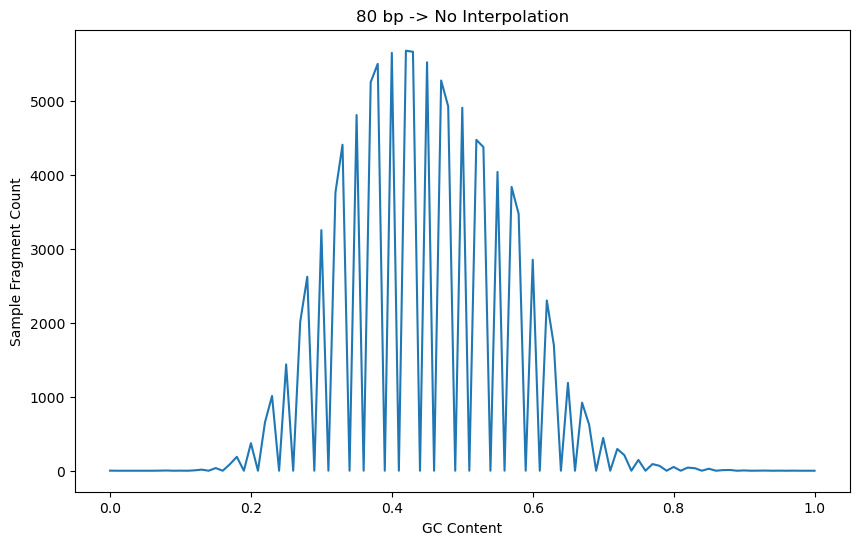

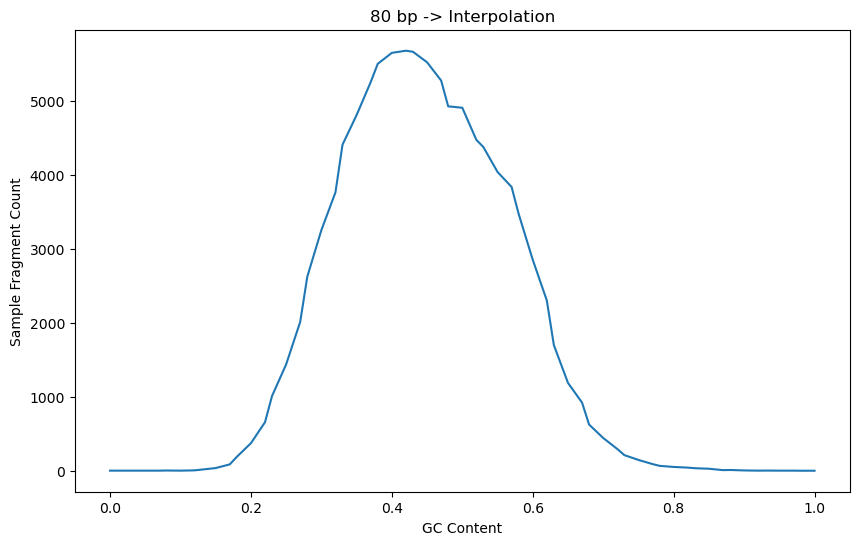

In [22]:
def process_length_level(sample):
    raw_sample = np.sum(sample, axis=0)
    processed_sample = np.zeros( raw_sample.shape )
    for i in range(raw_sample.shape[0]):
        processed_sample[i, :] = interpolate_zero_elements(np.copy(raw_sample[i, :]))
    return raw_sample, processed_sample


def plot_bias_curve(len_GC_array, length, ref_len_GC_array, title, image_file):
    lower_cnt, upper_cnt = 20, 80
    sample = len_GC_array[length - 51, :]
    ref = ref_len_GC_array[length - 51, :]
    Y = sample
    X = [float(i/100) for i in range(0, 101)]
    plt.figure(figsize=(10, 6))
    plt.xlabel('GC Content')
    plt.ylabel('Sample Fragment Count')
    plt.title(title)
    plt.plot(X, Y)
    plt.savefig(f'subfigures/{image_file}.png', dpi=300)

    
def main_func(cohort, sample_name):
    print(cohort, sample_name)
    global ref_GC_array
    lengths = [80]
    _, ref_len_GC_array = process_length_level(ref_GC_array)
    sample = np.load(f'{root_folder}/single_position_analysis_22_350_101_samples/{cohort}/{sample_name}.npy')
    raw_sample, processed_sample = process_length_level(sample)
    for length in lengths:
        plot_bias_curve(raw_sample, length, ref_len_GC_array, f'{length} bp -> No Interpolation', 'no_interpolation')
        plot_bias_curve(processed_sample, length, ref_len_GC_array, f'{length} bp -> Interpolation', 'interpolation')
        print('..................................................................................................................')

main_func('healthy_invitro', 'WHC1384')

healthy_invitro WHC1384
..................................................................................................................


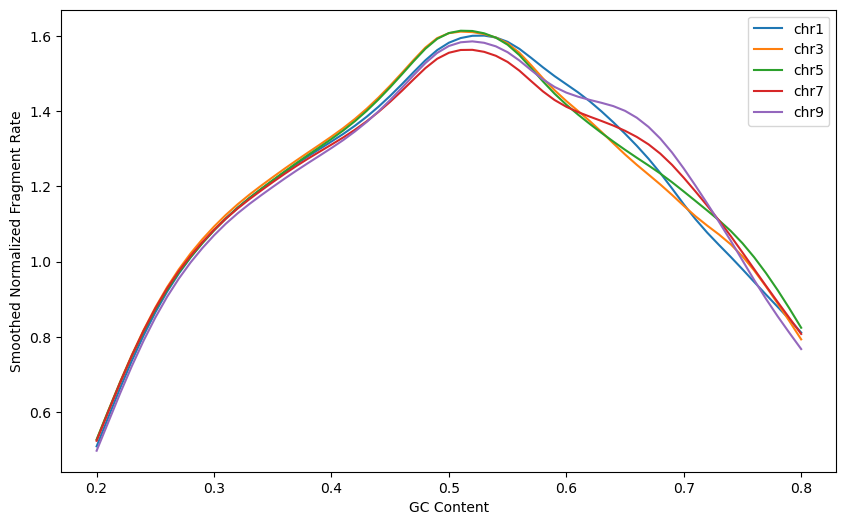

In [23]:
lower_cnt, upper_cnt = 10, 90
thr = 3
lag = 10

def process_chr_level(sample):
    chr_sample = np.sum(sample, axis=1)
    processed_sample = np.zeros( chr_sample.shape )
    for i in range(chr_sample.shape[0]):
        processed_sample[i, :] = interpolate_zero_elements(chr_sample[i, :])
    return processed_sample


def remove_outlier(arr):
    high = np.percentile(arr, 100-thr)
    low = np.percentile(arr, thr)
    arr = np.where(arr>high, high, arr)
    arr = np.where(arr<low, low, arr)
    return arr

def construct_GC_bias(sample, ref, X):
    global lower_cnt, upper_cnt
    safe_ref = np.where(ref == 0, 1, ref)
    GC_array = sample / safe_ref
    GC_array = GC_array[lower_cnt: upper_cnt+1]
    GC_array = remove_outlier(GC_array)
    GC_array = GC_array / np.mean(GC_array)
    lowess = sm.nonparametric.lowess(GC_array, X, frac=0.2)
    GC_array = lowess[:, 1]
    GC_array = GC_array / np.mean(GC_array)
    return GC_array


def plot_chr_bias(sample_chr_GC_array, ref_chr_GC_array, chr_list):
    global lower_cnt, upper_cnt
    plt.figure(figsize=(10, 6))
    X = [float(i/100) for i in range(lower_cnt, upper_cnt+1)]
    for i in chr_list:
        Y = construct_GC_bias(sample_chr_GC_array[i-1], ref_chr_GC_array[i-1], X)
        plt.plot(X[lag:-lag], Y[lag:-lag], label='chr{i}'.format(i=i))
    plt.xlabel('GC Content')
    plt.ylabel('Smoothed Normalized Fragment Rate')
    plt.legend()
    plt.savefig('subfigures/chr_bias.png', dpi=300)
    

def main_func(cohort, sample_name, contig_list):
    print(cohort, sample_name)
    global ref_GC_array
    ref_chr_GC_array = process_chr_level(ref_GC_array)
    sample = np.load(f'{root_folder}/single_position_analysis_22_350_101_samples/{cohort}/{sample_name}.npy')
    processed_sample = process_chr_level(sample)
    plot_chr_bias(processed_sample, ref_chr_GC_array, contig_list)
    print('..................................................................................................................')


contig_list = [1, 3, 5, 7, 9] 
main_func('healthy_invitro', 'WHC1384', contig_list)

healthy_c2i WHC565.sort
.................................................................................................................


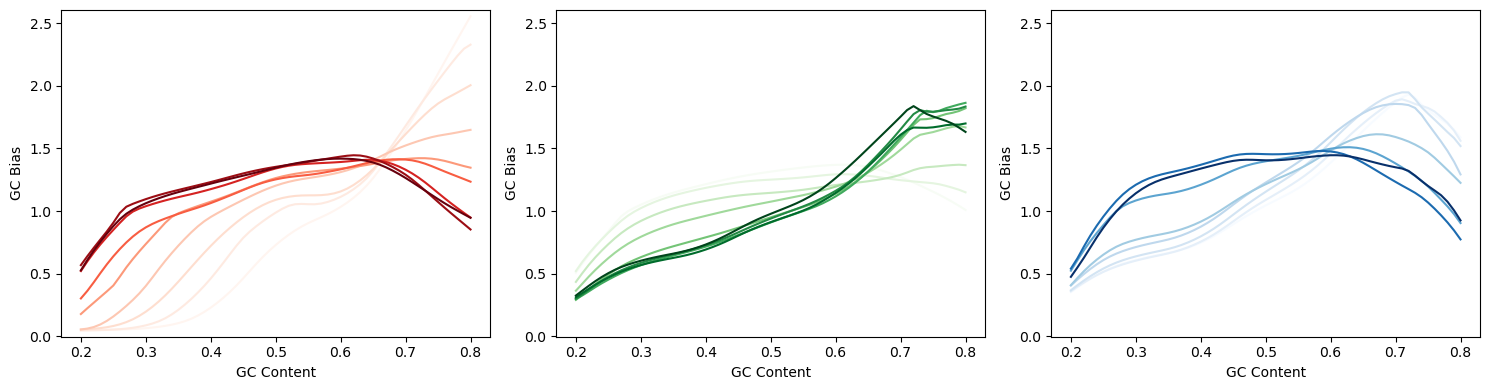

In [4]:
lower_cnt, upper_cnt = 10, 90
thr = 3
lag = 10


len_group_dic = {51: [51, 55],
                     52: [51, 55],
                     399: [396, 400],
                     400: [396, 400]}
for length in range(53, 399):
    len_group_dic[length] = [length-2, length+2]
    

def process_length_level(sample):
    raw_sample = np.sum(sample, axis=0)
    processed_sample = np.zeros( raw_sample.shape )
    for i in range(raw_sample.shape[0]):
        processed_sample[i, :] = interpolate_zero_elements(np.copy(raw_sample[i, :]))
    return processed_sample


def remove_outlier(arr):
    high = np.percentile(arr, 100-thr)
    low = np.percentile(arr, thr)
    arr = np.where(arr>high, high, arr)
    arr = np.where(arr<low, low, arr)
    return arr


def construct_GC_bias(sample_lengths, ref_lengths, X):
    sample = np.sum(sample_lengths, axis=0)
    ref = np.sum(ref_lengths, axis=0)
    safe_ref = ref + 1
    GC_array = sample / safe_ref
    
    GC_array = GC_array[lower_cnt: upper_cnt+1]
    GC_array = remove_outlier(GC_array)
    GC_array = GC_array / np.mean(GC_array)
    
    lowess = sm.nonparametric.lowess(GC_array, X, frac=0.2)
    GC_array = lowess[:, 1]
    GC_array = GC_array / np.mean(GC_array)
    return GC_array


def plot_len_GC_bias(sample_len_GC_array, frag_len, ref_len_GC_array, color, ax):
    global len_group_dic 
    X = [float(i/100) for i in range(lower_cnt, upper_cnt+1)]
    start_len_ind = len_group_dic[frag_len][0] - 51
    end_len_ind = len_group_dic[frag_len][1] - 51
    Y = construct_GC_bias(sample_len_GC_array[start_len_ind: end_len_ind+1], ref_len_GC_array[start_len_ind: end_len_ind+1], X)
    Y = Y[lag: -lag]
    min_thr = min(1/20, np.percentile(Y, 1))
    Y[Y<min_thr] = min_thr
    ax.plot(X[lag:-lag], Y, label=f'{frag_len}bp', color=color)
    return np.min(Y), np.max(Y)
    
    
def main_func(cohort, sample_name):
    print(cohort, sample_name)
    color_list = ['Reds', 'Greens', 'Blues']
    length_lists = [[51, 60, 70, 80, 100, 125, 150, 175, 190], [200, 210, 220, 230, 240, 250, 260, 270, 280],
                         [290, 300, 310, 320, 330, 350, 375, 400]]
    global ref_GC_array
    ref_len_GC_array = process_length_level(ref_GC_array)
    sample = np.load(f'{root_folder}/single_position_analysis_22_350_101_samples/{cohort}/{sample_name}.npy')
    processed_sample = process_length_level(sample)
    fig, axes = plt.subplots(1, 3, figsize=(15, 4))
    min_bias, max_bias = 10, -10
    for i in range(len(length_lists)):
        cmap = plt.get_cmap(color_list[i])
        lengths = length_lists[i]
        norm = mcolors.Normalize(vmin=min(lengths), vmax=max(lengths))
        for length in lengths:
            color = cmap(norm(length))
            temp_min, temp_max = plot_len_GC_bias(processed_sample, length, ref_len_GC_array, color, axes[i])
            min_bias = min(temp_min, min_bias)
            max_bias = max(temp_max, max_bias)
        axes[i].set_xlabel('GC Content')
        axes[i].set_ylabel('GC Bias')
        # axes[i].legend()
    for i in range(3):
        axes[i].set_ylim([min_bias-0.05, max_bias+0.05])
    plt.tight_layout()
    plt.savefig(f'subfigures/fragment_length_shift_no_legend.png', dpi=300)
    print('.................................................................................................................')
    
    
main_func('healthy_c2i', 'WHC565.sort')

healthy_c2i WHC565.sort
..................................................................................................................


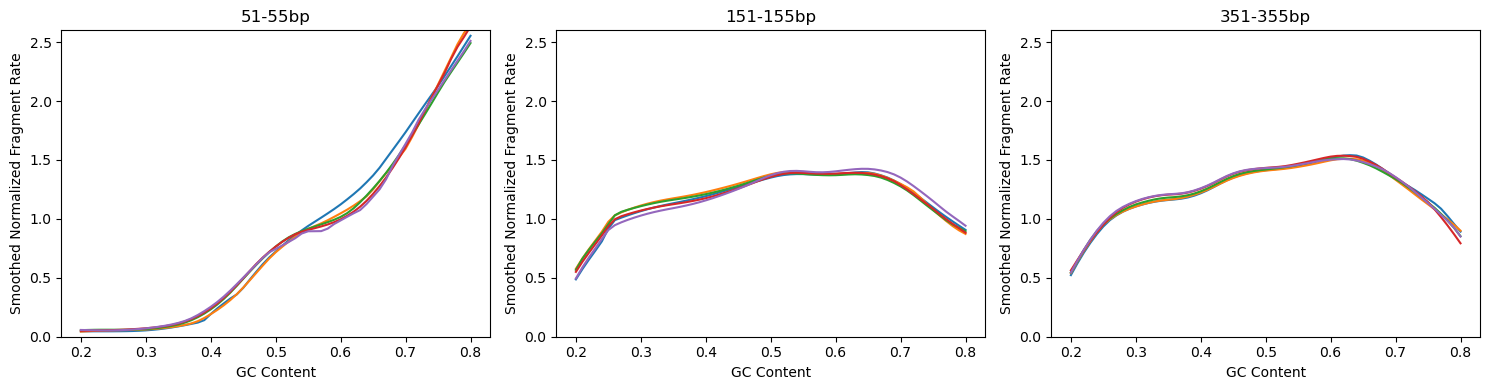

In [5]:
lower_cnt, upper_cnt = 10, 90
thr = 3
lag = 10


def process_length_level(sample):
    raw_sample = np.sum(sample, axis=0)
    processed_sample = np.zeros( raw_sample.shape )
    for i in range(raw_sample.shape[0]):
        processed_sample[i, :] = interpolate_zero_elements(np.copy(raw_sample[i, :]))
    return processed_sample


def remove_outlier(arr):
    high = np.percentile(arr, 100-thr)
    low = np.percentile(arr, thr)
    arr = np.where(arr>high, high, arr)
    arr = np.where(arr<low, low, arr)
    return arr


def construct_GC_bias(sample, ref, X):
    safe_ref = np.where(ref == 0, 1, ref)
    GC_array = sample / safe_ref
    GC_array = GC_array[lower_cnt: upper_cnt+1]
    GC_array = remove_outlier(GC_array)
    GC_array = GC_array / np.mean(GC_array)
    lowess = sm.nonparametric.lowess(GC_array, X, frac=0.15)
    GC_array = lowess[:, 1]
    GC_array = GC_array / np.mean(GC_array)
    return GC_array


def plot_len_group_bias(sample_len_GC_array, ref_len_GC_array, start_len, end_len, ax):
    global lower_cnt, upper_cnt
    X = [float(i/100) for i in range(lower_cnt, upper_cnt+1)]
    for length in range(start_len, end_len+1):
        Y = construct_GC_bias(sample_len_GC_array[length-51], ref_len_GC_array[length-51], X)
        ax.plot(X[lag:-lag], Y[lag:-lag])
    

def main_func(cohort, sample_name, len_list, window_size):
    print(cohort, sample_name)
    global ref_GC_array
    len_groups = []
    for length in len_list:
        len_groups.append([length, length+window_size-1])
    ref_len_GC_array = process_length_level(ref_GC_array)
    sample = np.load(f'{root_folder}/single_position_analysis_22_350_101_samples/{cohort}/{sample_name}.npy')
    processed_sample = process_length_level(sample)
    fig, axes = plt.subplots(1, 3, figsize=(15, 4))
    i = 0
    for len_group in len_groups:
        start_len, end_len = len_group[0], len_group[1]
        plot_len_group_bias(processed_sample, ref_len_GC_array, start_len, end_len, axes[i])
        axes[i].set_xlabel('GC Content')
        axes[i].set_ylabel('Smoothed Normalized Fragment Rate')
        axes[i].set_title(f'{start_len}-{end_len}bp')
        axes[i].set_ylim([0.0, 2.6])
        i+=1
    plt.tight_layout()
    plt.savefig(f'subfigures/fragment_length_merge.png', dpi=300)
    print('..................................................................................................................')
    
    

len_list = [51, 151, 351] 
# main_func('healthy_invitro', 'WHC1389', len_list, 5)
main_func('healthy_c2i', 'WHC565.sort', len_list, 5)

NCC_CRC-986_100215-CW-T-ready


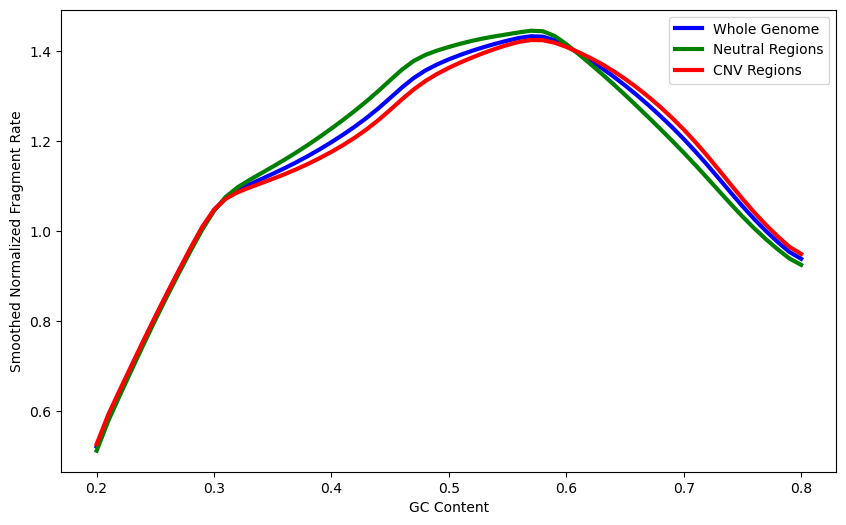

In [27]:
lower_cnt, upper_cnt = 10, 90
thr = 3
X = [float(i/100) for i in range(lower_cnt, upper_cnt+1)]
lag = 10

def process_sample_length_level(sample_file):
    raw_sample = np.load(sample_file)
    processed_sample = np.zeros( raw_sample.shape )
    for i in range(raw_sample.shape[0]):
        processed_sample[i, :] = interpolate_zero_elements(np.copy(raw_sample[i, :]))
    return processed_sample


def process_ref_length_level(sample):
    raw_sample = np.sum(sample, axis=0)
    processed_sample = np.zeros( raw_sample.shape )
    for i in range(raw_sample.shape[0]):
        processed_sample[i, :] = interpolate_zero_elements(np.copy(raw_sample[i, :]))
    return processed_sample


def remove_outlier(arr):
    high = np.percentile(arr, 100-thr)
    low = np.percentile(arr, thr)
    arr = np.where(arr>high, high, arr)
    arr = np.where(arr<low, low, arr)
    return arr


def construct_GC_bias(sample, ref, X):
    safe_ref = np.where(ref == 0, 1, ref)
    GC_array = sample / safe_ref
    GC_array = GC_array[lower_cnt: upper_cnt+1]
    GC_array = remove_outlier(GC_array)
    GC_array = GC_array / np.mean(GC_array)
    lowess = sm.nonparametric.lowess(GC_array, X, frac=0.3)
    GC_array = lowess[:, 1]
    GC_array = GC_array / np.mean(GC_array)
    return GC_array


def single_bias_plot(sample, ref_len_GC_array, label, color):
    global X
    sample = np.sum(sample, axis=0)
    ref_array = np.sum(ref_len_GC_array, axis=0)
    Y = construct_GC_bias(sample, ref_array, X)
    plt.plot(X[lag:-lag], Y[lag:-lag], label=label, linewidth=3, color=color)
    

def main_func(sample_name):
    folder = f'{root_folder}/cancer_GC_experiments'
    print(sample_name)
    global ref_GC_array
    ref_len_GC_array = process_ref_length_level(ref_GC_array)
    whole_sample = process_sample_length_level(f'{folder}/whole_genome/{sample_name}.npy')
    cnv_sample = process_sample_length_level(f'{folder}/cnv_regions/{sample_name}.npy')
    neutral_sample = process_sample_length_level(f'{folder}/neutral_regions/{sample_name}.npy')
    plt.figure(figsize=(10, 6))
    single_bias_plot(whole_sample, ref_len_GC_array, 'Whole Genome', 'blue')
    single_bias_plot(neutral_sample, ref_len_GC_array, 'Neutral Regions', 'green')
    single_bias_plot(cnv_sample, ref_len_GC_array, 'CNV Regions', 'red')
    plt.xlabel('GC Content')
    plt.ylabel('Smoothed Normalized Fragment Rate')
    plt.legend()
    plt.savefig('subfigures/cnv_neutral.png', dpi=300)


main_func('NCC_CRC-986_100215-CW-T-ready')